## CI PFI METHOD SHUFFLING FUTURE COVARIATES


In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

def load_data(dataset_name):
    df = pd.read_csv(f'{dataset_name}.csv')
    df['timestamp'] = pd.to_datetime(df['time_index'], unit='D', origin='2023-01-01')
    df.set_index('timestamp', inplace=True)
    df = df.drop('time_index', axis=1, errors='ignore')
    return df

def shuffle_covariate(covariates, column_name):
    shuffled_covariates = covariates.copy()
    values = shuffled_covariates.values()
    column_index = list(covariates.columns).index(column_name)
    np.random.shuffle(values[:, column_index])
    shuffled_df = pd.DataFrame(
        values,
        columns=covariates.columns,
        index=covariates.time_index
    )
    return TimeSeries.from_dataframe(shuffled_df)

def interval_score(y_true, y_pred_lower, y_pred_upper, alpha=0.2):
    y_true_values = y_true.values()
    lower_values = y_pred_lower.values()
    upper_values = y_pred_upper.values()
    
    coverage = np.mean((y_true_values >= lower_values) & (y_true_values <= upper_values))
    width = np.mean(upper_values - lower_values)
    return coverage - alpha * width

def create_model():
    return TFTModel(
        model_name="FINAL1_tft_targetv4",
        input_chunk_length=30,
        output_chunk_length=14,
        hidden_size=64,
        lstm_layers=2,
        num_attention_heads=4,
        batch_size=32,
        n_epochs=30,
        add_relative_index=True,
        log_tensorboard=True,
    )


def train_and_evaluate(target_variable, covariate_variables, df, num_samples):
    target = TimeSeries.from_series(df[target_variable].astype(np.float32))
    covariates = TimeSeries.from_dataframe(df[covariate_variables].astype(np.float32))

    train_test_split = int(0.9 * len(target))
    train_target, test_target = target[:train_test_split], target[train_test_split:]
    train_covariates, test_covariates = covariates[:train_test_split], covariates[train_test_split:]

    model = create_model()
    model.fit(train_target, past_covariates=train_covariates, verbose=True)

    predictions = model.predict(
        n=len(test_target),
        series=train_target,
        past_covariates=covariates,
        num_samples=num_samples
    )
    
    lower_pred = predictions.quantile_timeseries(0.1)
    upper_pred = predictions.quantile_timeseries(0.9)
    
    interval_score_value = interval_score(test_target, lower_pred, upper_pred)
    
    return model, interval_score_value, train_target, test_target, covariates, train_test_split

def run_pfi_analysis(df, num_samples):
    variables = df.columns.tolist()
    results = []

    for target_variable in variables:
        print(f"Processing target variable: {target_variable}")
        covariate_variables = [var for var in variables if var != target_variable]

        model, real_score, train_target, test_target, covariates, train_test_split = train_and_evaluate(
            target_variable, covariate_variables, df, num_samples
        )

        shuffle_scores = {}
        for covariate in covariate_variables:
            shuffled_covariates = shuffle_covariate(covariates, covariate)
            shuffled_predictions = model.predict(
                n=len(test_target),
                series=train_target,
                past_covariates=shuffled_covariates,
                num_samples=num_samples
            )
            
            lower_pred = shuffled_predictions.quantile_timeseries(0.1)
            upper_pred = shuffled_predictions.quantile_timeseries(0.9)
            
            shuffled_score = interval_score(test_target, lower_pred, upper_pred)
            shuffle_scores[covariate] = shuffled_score

            print(f"Shuffled {covariate}: shuffled_score = {shuffled_score}")

        results.append({
            'target': target_variable,
            'real_score': real_score,
            'shuffle_scores': shuffle_scores
        })

    return results

def save_results(results, dataset_name):
    os.makedirs('./PFI_results', exist_ok=True)
    with open(f'./PFI_results/{dataset_name}_interval_scores.json', 'w') as f:
        json.dump(results, f, indent=2)

def load_results(dataset_name):
    with open(f'./PFI_results/{dataset_name}_interval_scores.json', 'r') as f:
        return json.load(f)

def prepare_visualization_data(results):
    variables = [result['target'] for result in results]
    n_vars = len(variables)
    scores_before = np.array([result['real_score'] for result in results])
    scores_after = np.full((n_vars, n_vars), np.nan)

    for i, result in enumerate(results):
        for j, var in enumerate(variables):
            if var in result['shuffle_scores']:
                scores_after[i, j] = result['shuffle_scores'][var]

    pfi_ratios = scores_before[:, np.newaxis] / scores_after
    return variables, scores_before, scores_after, pfi_ratios

def save_plot(fig, filename):
    plt.savefig(os.path.join('./PFI_results', filename))
    plt.close(fig)

def plot_interval_scores(variables, scores_before, scores_after):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, (target, real_score) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        for shuffled_score in scores_after[i]:
            if not np.isnan(shuffled_score):
                ax.plot([1, 2], [real_score, shuffled_score], '-', color=color)
                ax.scatter([1, 2], [real_score, shuffled_score], color=color, s=100, zorder=5)
        ax.text(0.9, real_score, target, ha='right', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'], fontsize=12)
    ax.set_ylabel('Interval Score', fontsize=12)
    ax.set_title('(a) Interval scores before and after permutation', fontsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    save_plot(fig, 'interval_scores.png')

def plot_pfi_ratios(variables, pfi_ratios):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(pfi_ratios, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, vmin=0, vmax=2,
                xticklabels=variables, yticklabels=variables)
    ax.set_title('(b) PFI ratio between variables (Interval Score)', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    save_plot(fig, 'pfi_ratios_interval_score.png')

def plot_adjacency_matrix(variables, pfi_ratios, threshold=0.8):
    adjacency_matrix = (pfi_ratios < threshold).astype(int)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(adjacency_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=variables, yticklabels=variables)
    ax.set_title('(c) Final adjacency matrix based on Interval Score PFI', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    save_plot(fig, 'adjacency_matrix_interval_score.png')

def main(dataset_name, num_samples):
    df = load_data(dataset_name)
    results = run_pfi_analysis(df, num_samples)
    save_results(results, dataset_name)
    
    results = load_results(dataset_name)
    variables, scores_before, scores_after, pfi_ratios = prepare_visualization_data(results)
    
    plot_interval_scores(variables, scores_before, scores_after)
    plot_pfi_ratios(variables, pfi_ratios)
    plot_adjacency_matrix(variables, pfi_ratios)

if __name__ == "__main__":
    dataset_name = "synthetic_data_harvard_0"
    num_samples=100
    main(dataset_name, num_samples)





GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Processing target variable: V1
Epoch 29: 100%|██████████| 112/112 [00:08<00:00, 12.55it/s, v_num=logs, train_loss=1.710]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 112/112 [00:08<00:00, 12.55it/s, v_num=logs, train_loss=1.710]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.45it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V2: shuffled_score = 0.3255525781593285
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.45it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V3: shuffled_score = 0.2896278569810557
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.41it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled V4: shuffled_score = 0.22648866553488178
Processing target variable: V2
Epoch 1:  98%|█████████▊| 110/112 [00:08<00:00, 13.16it/s, v_num=logs, train_loss=2.620]

/Users/florisschouw/.pyenv/versions/3.10.14/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.48it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.50it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V1: shuffled_score = 0.467192638131231
Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.50it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V3: shuffled_score = 0.4824555719673632
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.50it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled V4: shuffled_score = 0.4880278773792087
Processing target variable: V3
Epoch 1:  26%|██▌       | 29/112 [00:02<00:06, 12.19it/s, v_num=logs, train_loss=2.950] 

/Users/florisschouw/.pyenv/versions/3.10.14/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.47it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.47it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V1: shuffled_score = 0.45313488011029535
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.49it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V2: shuffled_score = 0.47598991062566626
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.48it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled V4: shuffled_score = 0.46729381401559794
Processing target variable: V4
Epoch 12:  75%|███████▌  | 84/112 [00:06<00:02, 13.99it/s, v_num=logs, train_loss=1.620] 

/Users/florisschouw/.pyenv/versions/3.10.14/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Processing target variable: V1



   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K | train
8  | static_context_cell_encoder_grn   | _GatedResidualNetwork            | 16.8 K 

Epoch 29: 100%|██████████| 112/112 [00:07<00:00, 14.30it/s, v_num=logs, train_loss=1.890]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 112/112 [00:07<00:00, 14.29it/s, v_num=logs, train_loss=1.890]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.37it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.50it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V2: interval_score = 0.23953422493617965, point_score = 1.0583759165554387
Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.51it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V3: interval_score = 0.30931732482742513, point_score = 1.0659815065537983
Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.51it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled V4: interval_score = 0.24748222855471536, point_score = 1.2313345562464744
Processing target variable: V2
Epoch 29: 100%|██████████| 112/112 [00:09<00:00, 11.82it/s, v_num=logs, train_loss=3.530]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 112/112 [00:09<00:00, 11.82it/s, v_num=logs, train_loss=3.530]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.40it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.49it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V1: interval_score = 0.45335987785910253, point_score = 0.6928337613674057
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.47it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V3: interval_score = 0.49726129170963534, point_score = 0.6349148857095157
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.46it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled V4: interval_score = 0.5031632163873407, point_score = 0.6419541080864293
Processing target variable: V3
Epoch 29: 100%|██████████| 112/112 [00:11<00:00,  9.46it/s, v_num=logs, train_loss=1.350]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 112/112 [00:11<00:00,  9.45it/s, v_num=logs, train_loss=1.350]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  0.32it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.40it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.



Shuffled V1: interval_score = 0.2447375155642628, point_score = 0.7174783362080597


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.40it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V2: interval_score = 0.3833745429909322, point_score = 0.6103636426082061
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.37it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled V4: interval_score = 0.33988294984290834, point_score = 0.6697771860995494
Processing target variable: V4
Epoch 29: 100%|██████████| 112/112 [00:10<00:00, 10.87it/s, v_num=logs, train_loss=1.150]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 112/112 [00:10<00:00, 10.87it/s, v_num=logs, train_loss=1.150]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.38it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V1: interval_score = 0.4795228724508547, point_score = 0.2410584809384998
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.40it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V2: interval_score = 0.5658915268254233, point_score = 0.20590377002939397
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.42it/s]
Shuffled V3: interval_score = 0.5908966444798278, point_score = 0.2061574286076609


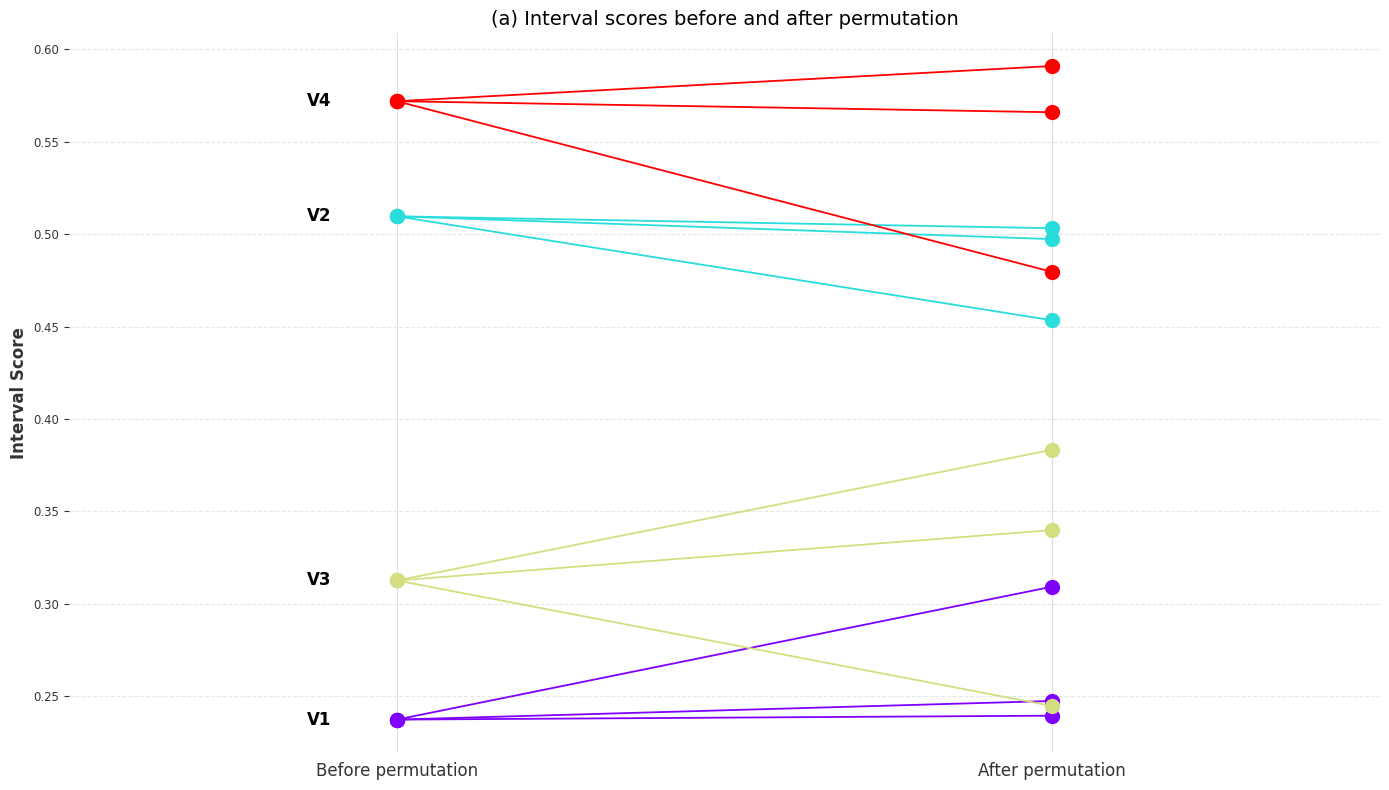

<Figure size 640x480 with 0 Axes>

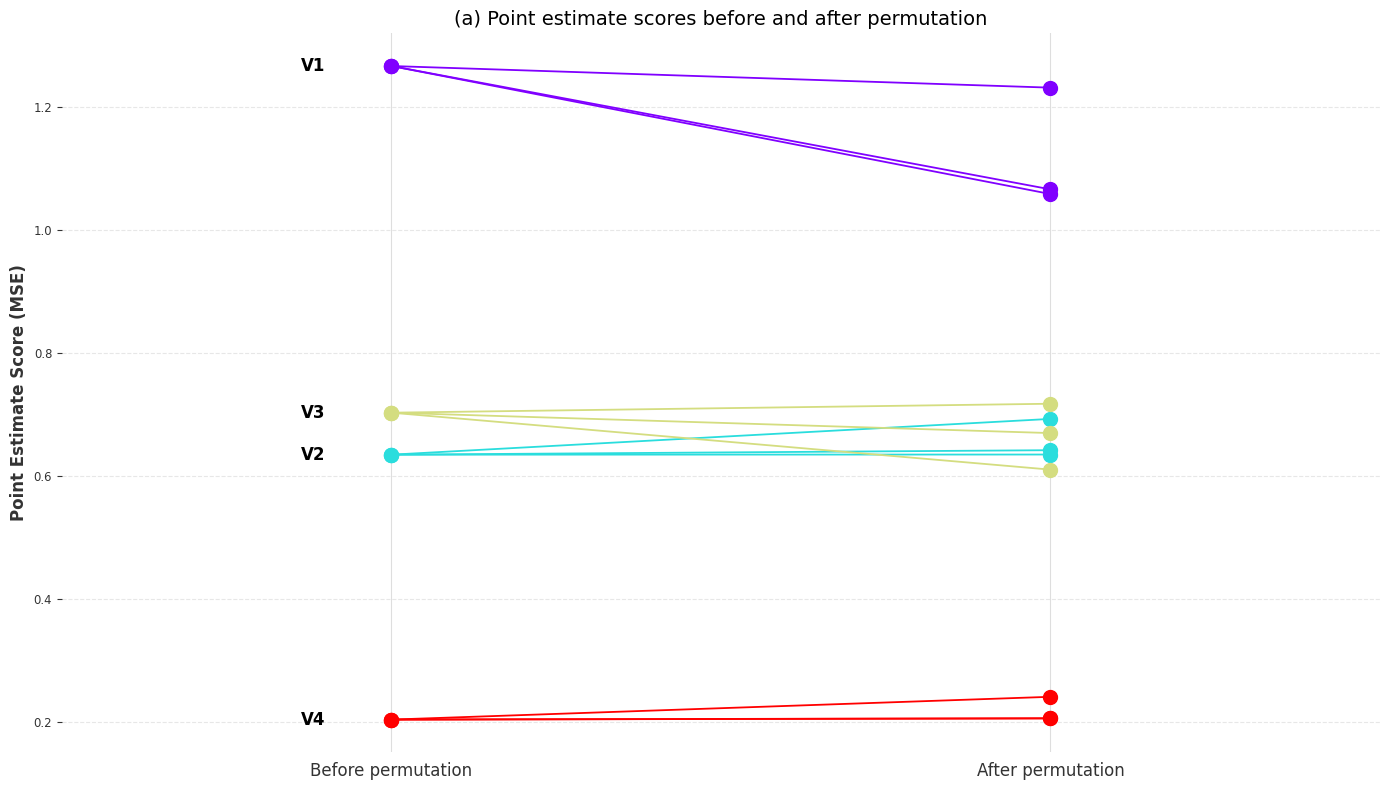

<Figure size 640x480 with 0 Axes>

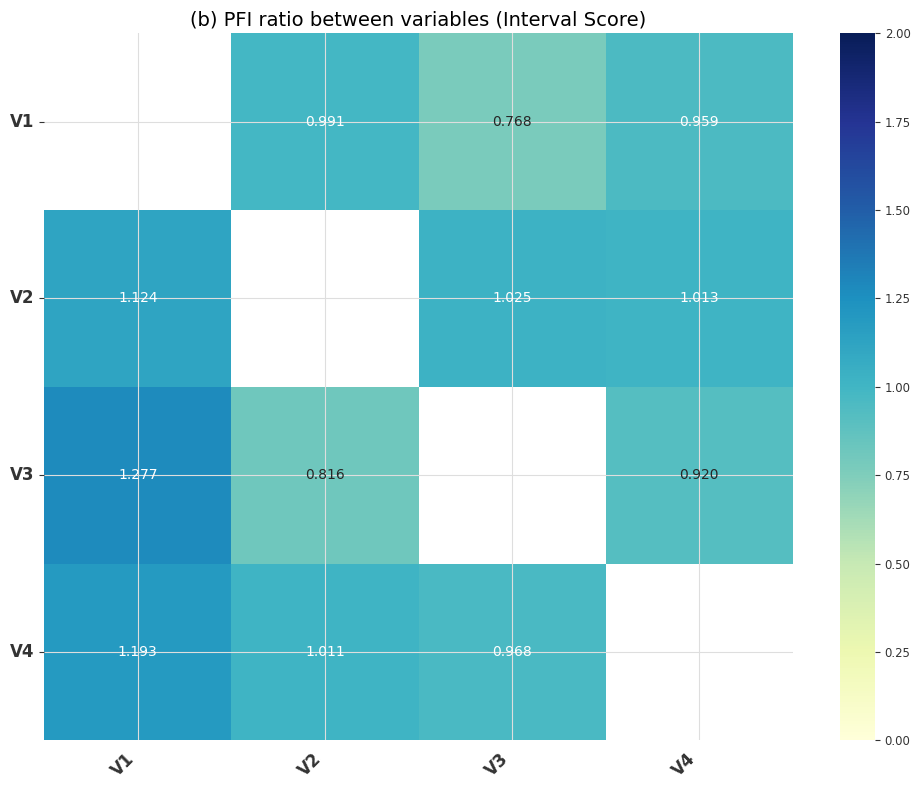

<Figure size 640x480 with 0 Axes>

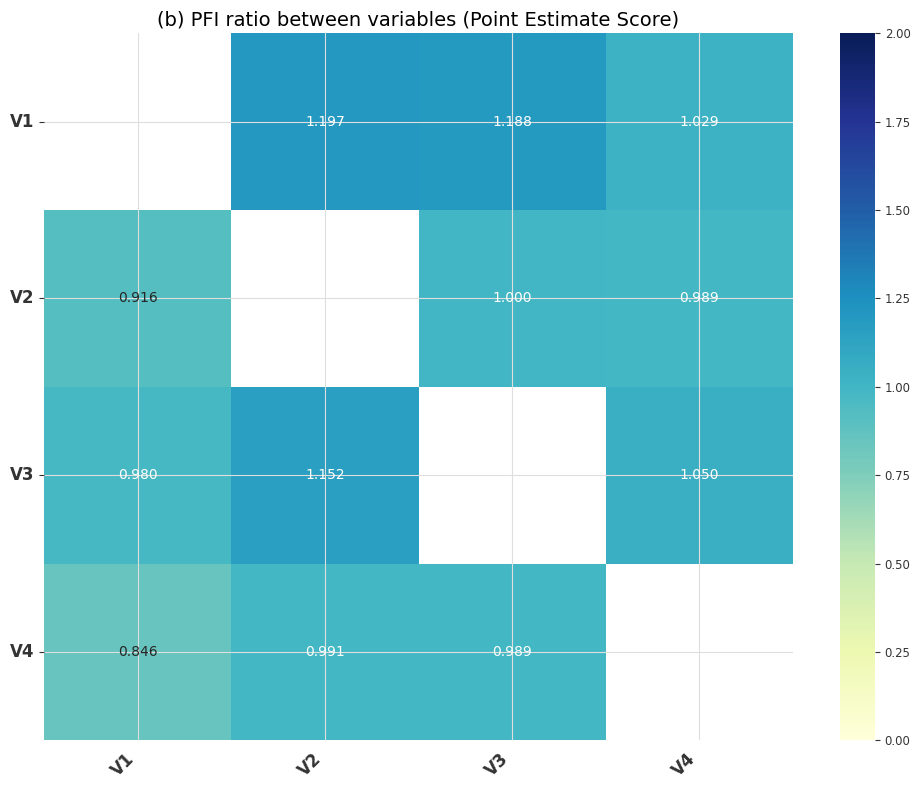

<Figure size 640x480 with 0 Axes>

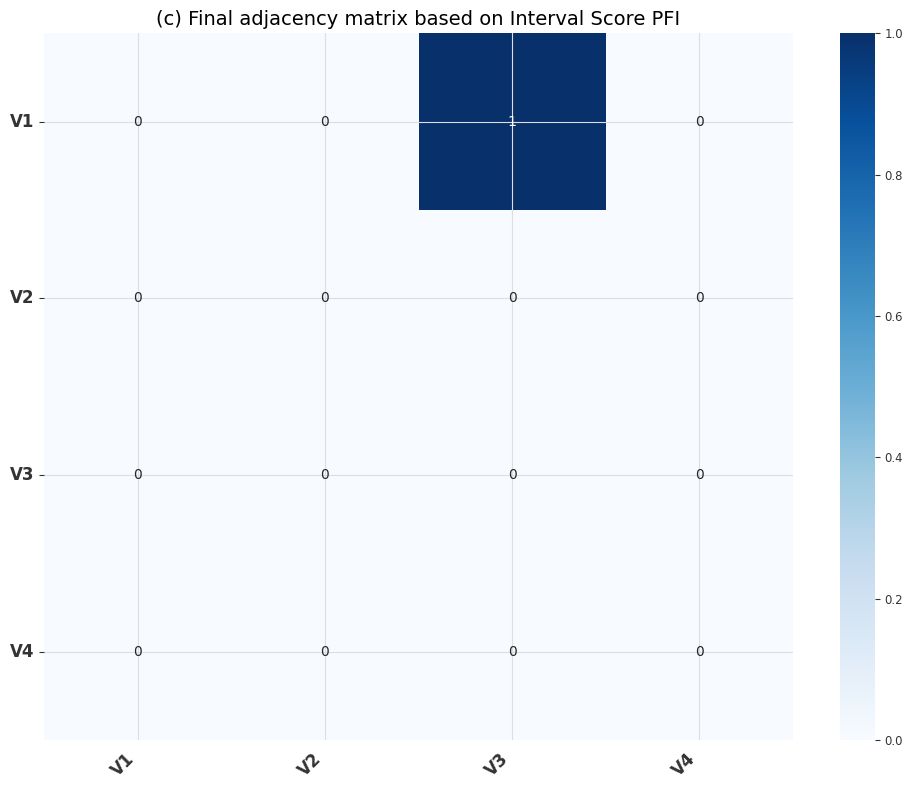

<Figure size 640x480 with 0 Axes>

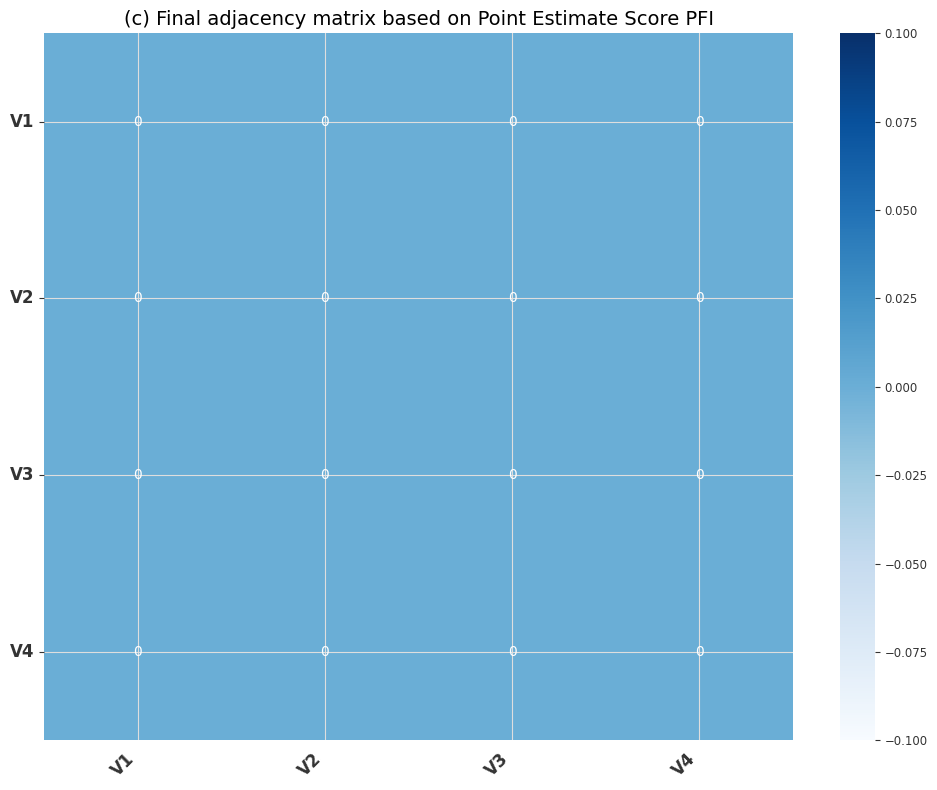

<Figure size 640x480 with 0 Axes>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

def load_data(dataset_name):
    df = pd.read_csv(f'{dataset_name}.csv')
    df['timestamp'] = pd.to_datetime(df['time_index'], unit='D', origin='2023-01-01')
    df.set_index('timestamp', inplace=True)
    df = df.drop('time_index', axis=1, errors='ignore')
    return df

def shuffle_covariate(covariates, column_name):
    shuffled_covariates = covariates.copy()
    values = shuffled_covariates.values()
    column_index = list(covariates.columns).index(column_name)
    np.random.shuffle(values[:, column_index])
    shuffled_df = pd.DataFrame(
        values,
        columns=covariates.columns,
        index=covariates.time_index
    )
    return TimeSeries.from_dataframe(shuffled_df)

def point_estimate_score(y_true, y_pred):
    return mse(y_true, y_pred)

def interval_score(y_true, y_pred_lower, y_pred_upper, alpha=0.2):
    y_true_values = y_true.values()
    lower_values = y_pred_lower.values()
    upper_values = y_pred_upper.values()
    
    coverage = np.mean((y_true_values >= lower_values) & (y_true_values <= upper_values))
    width = np.mean(upper_values - lower_values)
    return coverage - alpha * width

def create_model():
    return TFTModel(
        model_name="FINAL1_tft_targetv4",
        input_chunk_length=30,
        output_chunk_length=14,
        hidden_size=64,
        lstm_layers=2,
        num_attention_heads=4,
        batch_size=32,
        n_epochs=30,
        add_relative_index=True,
        log_tensorboard=True,
    )


def train_and_evaluate(target_variable, covariate_variables, df, num_samples):
    target = TimeSeries.from_series(df[target_variable].astype(np.float32))
    covariates = TimeSeries.from_dataframe(df[covariate_variables].astype(np.float32))

    train_test_split = int(0.9 * len(target))
    train_target, test_target = target[:train_test_split], target[train_test_split:]
    train_covariates, test_covariates = covariates[:train_test_split], covariates[train_test_split:]

    model = create_model()
    model.fit(train_target, past_covariates=train_covariates, verbose=True)

    predictions = model.predict(
        n=len(test_target),
        series=train_target,
        past_covariates=covariates,
        num_samples=num_samples
    )
    
    lower_pred = predictions.quantile_timeseries(0.1)
    median_pred = predictions.quantile_timeseries(0.5)
    upper_pred = predictions.quantile_timeseries(0.9)
    
    interval_score_value = interval_score(test_target, lower_pred, upper_pred)
    point_estimate_score_value = point_estimate_score(test_target, median_pred)
    
    return model, interval_score_value, point_estimate_score_value, train_target, test_target, covariates, train_test_split


def run_pfi_analysis(df, num_samples):
    variables = df.columns.tolist()
    results = []

    for target_variable in variables:
        print(f"Processing target variable: {target_variable}")
        covariate_variables = [var for var in variables if var != target_variable]

        model, real_interval_score, real_point_score, train_target, test_target, covariates, train_test_split = train_and_evaluate(
            target_variable, covariate_variables, df, num_samples
        )

        shuffle_interval_scores = {}
        shuffle_point_scores = {}
        for covariate in covariate_variables:
            shuffled_covariates = shuffle_covariate(covariates, covariate)
            shuffled_predictions = model.predict(
                n=len(test_target),
                series=train_target,
                past_covariates=shuffled_covariates,
                num_samples=num_samples
            )
            
            lower_pred = shuffled_predictions.quantile_timeseries(0.1)
            median_pred = shuffled_predictions.quantile_timeseries(0.5)
            upper_pred = shuffled_predictions.quantile_timeseries(0.9)
            
            shuffled_interval_score = interval_score(test_target, lower_pred, upper_pred)
            shuffled_point_score = point_estimate_score(test_target, median_pred)
            
            shuffle_interval_scores[covariate] = shuffled_interval_score
            shuffle_point_scores[covariate] = shuffled_point_score

            print(f"Shuffled {covariate}: interval_score = {shuffled_interval_score}, point_score = {shuffled_point_score}")

        results.append({
            'target': target_variable,
            'real_interval_score': real_interval_score,
            'real_point_score': real_point_score,
            'shuffle_interval_scores': shuffle_interval_scores,
            'shuffle_point_scores': shuffle_point_scores
        })

    return results



def save_results(results, dataset_name):
    os.makedirs('./PFI_results', exist_ok=True)
    with open(f'./PFI_results/{dataset_name}_interval_scores.json', 'w') as f:
        json.dump(results, f, indent=2)

def load_results(dataset_name):
    with open(f'./PFI_results/{dataset_name}_interval_scores.json', 'r') as f:
        return json.load(f)


def prepare_visualization_data(results):
    variables = [result['target'] for result in results]
    n_vars = len(variables)
    
    interval_scores_before = np.array([result['real_interval_score'] for result in results])
    point_scores_before = np.array([result['real_point_score'] for result in results])
    
    interval_scores_after = np.full((n_vars, n_vars), np.nan)
    point_scores_after = np.full((n_vars, n_vars), np.nan)

    for i, result in enumerate(results):
        for j, var in enumerate(variables):
            if var in result['shuffle_interval_scores']:
                interval_scores_after[i, j] = result['shuffle_interval_scores'][var]
                point_scores_after[i, j] = result['shuffle_point_scores'][var]

    interval_pfi_ratios = interval_scores_before[:, np.newaxis] / interval_scores_after
    point_pfi_ratios = point_scores_before[:, np.newaxis] / point_scores_after
    
    return variables, interval_scores_before, interval_scores_after, point_scores_before, point_scores_after, interval_pfi_ratios, point_pfi_ratios


def save_plot(fig, filename):
    plt.savefig(os.path.join('./PFI_results', filename))
    plt.close(fig)

def plot_interval_scores(variables, scores_before, scores_after):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, (target, real_score) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        for shuffled_score in scores_after[i]:
            if not np.isnan(shuffled_score):
                ax.plot([1, 2], [real_score, shuffled_score], '-', color=color)
                ax.scatter([1, 2], [real_score, shuffled_score], color=color, s=100, zorder=5)
        ax.text(0.9, real_score, target, ha='right', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'], fontsize=12)
    ax.set_ylabel('Interval Score', fontsize=12)
    ax.set_title('(a) Interval scores before and after permutation', fontsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    save_plot(fig, 'interval_scores.png')

def plot_point_scores(variables, scores_before, scores_after):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, (target, real_score) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        for shuffled_score in scores_after[i]:
            if not np.isnan(shuffled_score):
                ax.plot([1, 2], [real_score, shuffled_score], '-', color=color)
                ax.scatter([1, 2], [real_score, shuffled_score], color=color, s=100, zorder=5)
        ax.text(0.9, real_score, target, ha='right', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'], fontsize=12)
    ax.set_ylabel('Point Estimate Score (MSE)', fontsize=12)
    ax.set_title('(a) Point estimate scores before and after permutation', fontsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    save_plot(fig, 'point_estimate_scores.png')


def plot_pfi_ratios(variables, pfi_ratios, score_type):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(pfi_ratios, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, vmin=0, vmax=2,
                xticklabels=variables, yticklabels=variables)
    ax.set_title(f'(b) PFI ratio between variables ({score_type})', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    save_plot(fig, f'pfi_ratios_{score_type.lower().replace(" ", "_")}.png')

def plot_adjacency_matrix(variables, pfi_ratios, score_type, threshold=0.8):
    adjacency_matrix = (pfi_ratios < threshold).astype(int)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(adjacency_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=variables, yticklabels=variables)
    ax.set_title(f'(c) Final adjacency matrix based on {score_type} PFI', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    save_plot(fig, f'adjacency_matrix_{score_type.lower().replace(" ", "_")}.png')

def main(dataset_name, num_samples):
    df = load_data(dataset_name)
    results = run_pfi_analysis(df, num_samples)
    save_results(results, dataset_name)
    
    results = load_results(dataset_name)
    variables, interval_scores_before, interval_scores_after, point_scores_before, point_scores_after, interval_pfi_ratios, point_pfi_ratios = prepare_visualization_data(results)
    
    plot_interval_scores(variables, interval_scores_before, interval_scores_after)
    plot_point_scores(variables, point_scores_before, point_scores_after)
    plot_pfi_ratios(variables, interval_pfi_ratios, "Interval Score")
    plot_pfi_ratios(variables, point_pfi_ratios, "Point Estimate Score")
    plot_adjacency_matrix(variables, interval_pfi_ratios, "Interval Score")
    plot_adjacency_matrix(variables, point_pfi_ratios, "Point Estimate Score")


if __name__ == "__main__":
    dataset_name = "synthetic_data_harvard_0"
    num_samples=100
    main(dataset_name, num_samples)





In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import math
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
from darts.utils.likelihood_models import QuantileRegression  # Import the correct likelihood
from copy import deepcopy
# Ensure reproducibility
np.random.seed(42)

# Specify your dataset name
dataset_name = 'synthetic_data_harvard_0'

# Create a directory to save results and plots for this dataset
results_dir = f'./PFI_results/{dataset_name}'
os.makedirs(results_dir, exist_ok=True)

# Load your dataset
df = pd.read_csv(f'{dataset_name}.csv')
df['timestamp'] = pd.to_datetime(df['time_index'], unit='D', origin='2023-01-01')
df.set_index('timestamp', inplace=True)
df = df.drop('time_index', axis=1, errors='ignore')

# List of all variables
variables = df.columns.tolist()
results = []
num_samples = 100  # Number of samples for probabilistic forecasting
confidence_level = 0.95
alpha = 1 - confidence_level

# Function to shuffle covariate
def shuffle_covariate(covariates, column_name, train_length):
    shuffled_covariates = covariates.copy()
    values = shuffled_covariates.values(copy=False)
    column_index = list(covariates.columns).index(column_name)
    np.random.shuffle(values[train_length:, column_index])
    return shuffled_covariates

# Function to compute loss distribution
def compute_loss_distribution(actual_series, prediction_samples):
    losses = []
    for i in range(prediction_samples.n_samples):
        sample_prediction = prediction_samples.univariate_values()[:, i]
        loss = mse(actual_series.values(), sample_prediction)
        losses.append(loss)
    return np.array(losses)

# Loop over each variable as the target
for target_variable in variables:
    print(f"Processing target variable: {target_variable}")
    covariate_variables = [var for var in variables if var != target_variable]

    # Prepare the data
    target_series = TimeSeries.from_series(df[target_variable].astype(np.float32))
    covariates = TimeSeries.from_dataframe(df[covariate_variables].astype(np.float32))

    # Split into training and testing sets
    train_test_split = int(0.9 * len(target_series))
    train_target, test_target = target_series[:train_test_split], target_series[train_test_split:]
    train_covariates = covariates[:train_test_split]
    test_covariates = covariates[train_test_split:]

    # Define and train the model
    model = TFTModel(
        input_chunk_length=30,
        output_chunk_length=14,
        hidden_size=64,
        lstm_layers=2,
        num_attention_heads=4,
        batch_size=32,
        n_epochs=30,  # Adjust epochs as needed
        add_relative_index=True,
        random_state=42,
        likelihood=QuantileRegression()  # Use an instance of QuantileRegression
    )

    model.fit(
        series=train_target,
        past_covariates=covariates,
        future_covariates=covariates,
        verbose=False
    )

    # Generate probabilistic forecasts
    real_predictions = model.predict(
        n=len(test_target),
        series=train_target,
        past_covariates=covariates,
        future_covariates=covariates,
        num_samples=num_samples
    )

    # Compute real loss distribution
    real_loss_distribution = compute_loss_distribution(test_target, real_predictions)
    real_loss_mean = np.mean(real_loss_distribution)

    # Dictionary to store shuffled loss distributions and PFI scores
    shuffled_loss_distributions = {}
    pfi_score_distributions = {}

    # Calculate losses and PFI scores for each covariate
    for covariate in covariate_variables:
        # Shuffle the covariate
        shuffled_covariates = shuffle_covariate(covariates, covariate, train_test_split)

        # Generate predictions with shuffled covariate
        shuffled_predictions = model.predict(
            n=len(test_target),
            series=train_target,
            past_covariates=covariates,
            future_covariates=shuffled_covariates,
            num_samples=num_samples
        )

        # Compute shuffled loss distribution
        shuffled_loss_distribution = compute_loss_distribution(test_target, shuffled_predictions)
        shuffled_loss_mean = np.mean(shuffled_loss_distribution)
        shuffled_loss_distributions[covariate] = shuffled_loss_distribution

        # Compute PFI score distribution (lower values indicate higher importance)
        pfi_scores = real_loss_distribution / shuffled_loss_distribution
        pfi_score_distributions[covariate] = pfi_scores

    # Calculate confidence intervals for PFI scores
    pfi_confidence_intervals = {}
    for covariate, pfi_scores in pfi_score_distributions.items():
        lower = np.percentile(pfi_scores, 100 * (alpha / 2))
        upper = np.percentile(pfi_scores, 100 * (1 - alpha / 2))
        mean = np.mean(pfi_scores)
        pfi_confidence_intervals[covariate] = {
            'mean': mean,
            'lower': lower,
            'upper': upper
        }

    # Calculate PFI scores using point estimates
    real_point_prediction = real_predictions.quantile_timeseries(0.5)
    real_point_loss = mse(test_target, real_point_prediction)

    point_shuffle_losses = {}
    point_pfi_scores = {}
    for covariate in covariate_variables:
        shuffled_covariates = shuffle_covariate(covariates, covariate, train_test_split)
        shuffled_predictions = model.predict(
            n=len(test_target),
            series=train_target,
            past_covariates=covariates,
            future_covariates=shuffled_covariates,
            num_samples=1
        )
        point_prediction = shuffled_predictions.quantile_timeseries(0.5)
        shuffle_loss = mse(test_target, point_prediction)
        point_shuffle_losses[covariate] = shuffle_loss
        point_pfi_scores[covariate] = real_point_loss / shuffle_loss

    # Store the results
    result = {
        'target': target_variable,
        'real_loss_mean': real_loss_mean,
        'real_point_loss': real_point_loss,
        'pfi_confidence_intervals': pfi_confidence_intervals,
        'point_pfi_scores': point_pfi_scores
    }
    results.append(result)

# Save the results to a JSON file
results_file = os.path.join(results_dir, f'pfi_results_{dataset_name}.json')
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)

# Visualization
variables = [result['target'] for result in results]
n_vars = len(variables)

# Prepare data for plotting
for result in results:
    target = result['target']
    covariates = [var for var in variables if var != target]

    # Extract data
    pfi_means = [result['pfi_confidence_intervals'][cov]['mean'] for cov in covariates]
    pfi_lowers = [result['pfi_confidence_intervals'][cov]['mean'] - result['pfi_confidence_intervals'][cov]['lower'] for cov in covariates]
    pfi_uppers = [result['pfi_confidence_intervals'][cov]['upper'] - result['pfi_confidence_intervals'][cov]['mean'] for cov in covariates]
    point_pfi_scores = [result['point_pfi_scores'][cov] for cov in covariates]

    # Plot PFI scores with confidence intervals
    plt.figure(figsize=(12, 6))
    plt.bar(covariates, pfi_means, yerr=[pfi_lowers, pfi_uppers], capsize=5, alpha=0.7, label='Probabilistic PFI')
    plt.scatter(covariates, point_pfi_scores, color='red', label='Point Estimate PFI')
    plt.axhline(y=1.0, color='r', linestyle='--', label='No Effect Threshold')
    plt.xlabel('Covariates')
    plt.ylabel('PFI Ratio (Lower is More Important)')
    plt.title(f'PFI Ratios for Target Variable: {target}')
    plt.legend()
    plt.tight_layout()
    plot_file = os.path.join(results_dir, f'pfi_scores_{dataset_name}_{target}.png')
    plt.savefig(plot_file)
    plt.close()

# Aggregate PFI scores into matrices for heatmap
pfi_mean_matrix = np.zeros((n_vars, n_vars))
pfi_lower_matrix = np.zeros((n_vars, n_vars))
pfi_upper_matrix = np.zeros((n_vars, n_vars))

for i, result in enumerate(results):
    target = result['target']
    covariates = [var for var in variables if var != target]
    for cov in covariates:
        j = variables.index(cov)
        pfi_mean_matrix[i, j] = result['pfi_confidence_intervals'][cov]['mean']
        pfi_lower_matrix[i, j] = result['pfi_confidence_intervals'][cov]['lower']
        pfi_upper_matrix[i, j] = result['pfi_confidence_intervals'][cov]['upper']

# Plot heatmap of mean PFI ratios
plt.figure(figsize=(10, 8))
sns.heatmap(pfi_mean_matrix, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=variables, yticklabels=variables)
plt.title('Mean PFI Ratios Heatmap (Lower is More Important)')
plt.tight_layout()
heatmap_mean_file = os.path.join(results_dir, f'pfi_mean_heatmap_{dataset_name}.png')
plt.savefig(heatmap_mean_file)
plt.close()

# Plot heatmap of lower bounds
plt.figure(figsize=(10, 8))
sns.heatmap(pfi_lower_matrix, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=variables, yticklabels=variables)
plt.title('Lower Bound of PFI Ratios Heatmap')
plt.tight_layout()
heatmap_lower_file = os.path.join(results_dir, f'pfi_lower_heatmap_{dataset_name}.png')
plt.savefig(heatmap_lower_file)
plt.close()

# Plot heatmap of upper bounds
plt.figure(figsize=(10, 8))
sns.heatmap(pfi_upper_matrix, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=variables, yticklabels=variables)
plt.title('Upper Bound of PFI Ratios Heatmap')
plt.tight_layout()
heatmap_upper_file = os.path.join(results_dir, f'pfi_upper_heatmap_{dataset_name}.png')
plt.savefig(heatmap_upper_file)
plt.close()

print(f"PFI analysis complete. Results and plots saved in '{results_dir}' directory.")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Processing target variable: V1


`Trainer.fit` stopped: `max_epochs=30` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed